# Approximating $\pi$ from Human Trajectories in a Video Game

Approximating $\pi$ (~3.14159265358979323846) has been a task of immense interest for humans. There have been many ingenious methods to calculate $\pi$. Here, we explore a new one -- Can we approximate $\pi$ from human actions as they try to move in circles in a video game?

The answer is of course yes. Where there are circles, there must be $\pi$. In this work, we build upon one of the earliest methods humans developed to approximate $\pi$ from player trajectories. In ... BC, Archimedes devised a simple method to approximate $\pi$ by approximating circles with polygons. His many insight was that the higher the number of sides of the polygons, the better approximations they would be for circles.

Before going into the details of the methods, we will first look at its application in estimating $\pi$ from human trajectories in a video game. The game our human players played is Space Fortress (Mane and Donchin, 1989). The game was developed as a common complex task for several different research groups studying complex task learning. Still widely used. Have been the experimental paradigm for many theories of human decision-making and learning (e.g., Anderson...). Recently, thrown as a challenge for reinforcement learning (cite). 

In this game, players fly a ship in circles around the enemy HQ (i.e., the Space Fortress) and attack to destroy it. The optimal path is circles, which our players have been informed of. But, it is difficult to implement. The game controls dictate that the players have to construct the circles with straight lines. In other words, they have to approximate circles with polygons. A direct consequence is -- the better the polygons are as approximations of circles (which equates to, the higher number of straight lines as the sides of the polygons), the better would be the approximations of $\pi$ according to Archimedes' method to approximate $\pi$. Another way to look at it: Approximations of $\pi$ provides a measure of performance in moving in cirlces.

Then, we take a few minutes to marvel at the simple beauty of Archimedes' method and have some fun with it. Combining our knowledge of calculus, we devise a simple way to approximate $\pi$ to many digits using just our computers or, if needed, using a pocket calculator. This exercise is meant mostly for fun, but may come in handy if we find ourselves in need to quickly but accurately approximate $\pi$ in a doomsday situation with aliens invading us and we have no internet. We also discuss why this method worked in approximating $\pi$ from the actions of our human players.

Finally, we present a test bed for the readers, to animate players' trajectories in each game and compare them against the $\pi$ approximations.


Dataset description:

References:

Link to open-source dataset in osf.io: https://osf.io/v5mzx/

In [2]:

# NOTE: Game wise distance, velocity and angular velocity analyzer

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,12)
# sns.set(rc = {'axes.grid':False})
sns.reset_orig()
sns.set(style = 'ticks', font ='serif', font_scale = 1.2)
# sns.set(rc = {'axes.facecolor': 'black', 'figure.facecolor':'black'})
# sns.set_palette("pastel") # options: bright, pastel
sns.color_palette("husl", 9)
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black','figure.edgecolor':'black','axes.grid':False})

# from mpl_toolkits.mplot3d import Axes3D
# plt.rcParams["figure.figsize"] = (12,12)

# import scipy.signal as sg
# from sklearn.preprocessing import StandardScalper, scale
# # from sklearn import cross_validation
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LinearRegression
# from sklearn.cross_decomposition import PLSRegression, PLSSVD
# from sklearn.metrics import mean_squared_error

import copy
import time
# %matplotlib notebook
# from IPython.display import HTML
# plt.rcParams["animation.html"] = "jshtml"


## Approximating $\pi$ from Spatial Locations of Player Ship

We will use the (x,y) coordinates against time in these calculations. First, we will get the information into some convenient forms. Second, we estimate Pi values and third, we get the angular velocity.

We calculate Pi for each circle completed around the Fortress. So the Fortress is the center of every circle. To get Pi, we want to use the relationship perimeter S = $2\pi*r \Rightarrow \pi = \frac{S}{2r}$

The distance traveled by the ship in each circle is the "s" or the perimeter of the polygon/circle. For "r", we use the average distance of the ship from the Fortress.

In [3]:

# Euclidean distance between two points
def eu_distance(x1, y1, x2, y2):
	d = np.sqrt((x1-x2)**2 + (y1-y2)**2)
	return(d)

# Convert polar co-ordinates to complex numbers of form z = r*e^\theta
def polar2z(r,theta):
    return r * np.exp( 1j * theta )

# Version 1: Convert complex numbers of form z = r*e^\theta to z = (r, theta)
	# using defaults for angle, returns angle between -pi to pi or -180 to 180
def z2polar1(z):
    return ( np.abs(z), np.angle(z) )

# Version 2: Convert complex numbers of form z = r*e^\theta to z = (r, theta)
	# with my tweaks, returns angle between 0 to 2*pi or 0 to 360
def z2polar2(z): 
    angles = np.angle(z) # default return within -pi to pi
    # here, we implement an if condition: if the angle is negative, add 2pi with the angle
    angles[angles<0] = angles[angles<0] + 2*np.pi
    return ( np.abs(z),  angles)

convert_radtodeg = 180/np.pi
fortress_x = 355
fortress_y = 315

pi_all = []
pi_per_game = np.zeros([248,1])
mean_r_per_game = np.zeros([248,1])
total_d_per_game = np.zeros([248,1])

# ov_game_number = 10
game_list = np.arange(9,249) # [20, 120, 220] # Manual changes here!

# new_run = 1

# if (new_run):

# # ------------------- LOAD DATA -----------------------------
# # Loading the agg data from 2019-2020.
# # We also load the old complete file with aggregated data to add more information to it.

# 	agg_df = pd.read_csv("Complete_18Apr.csv")

# 	agg_df["X_arr"] = 0
# 	agg_df["Y_arr"] = 0
# 	agg_df["total_d_per_cycle"] = 0
# 	agg_df["mean_r_per_cycle"] = 0
# 	agg_df["pi_per_cycle"] = 0

# 	agg_df.X_arr = agg_df.X_arr.astype(object)
# 	agg_df.Y_arr = agg_df.Y_arr.astype(object)
# 	agg_df.total_d_per_cycle = agg_df.total_d_per_cycle.astype(object)
# 	agg_df.mean_r_per_cycle = agg_df.mean_r_per_cycle.astype(object)
# 	agg_df.pi_per_cycle = agg_df.pi_per_cycle.astype(object)
# 	# print(agg_df.pi_cycle)


# 	# -------------- Calculate Pi per cycle around the Fortress -------------------

# 	# Later we will average them over cycles to get game-wise approximations of Pi
# 	num_players = 9

# 	for player in range(1, num_players + 1):
# 		# player_df = pd.DataFrame(np.zeros([game_list.shape[0], 5]), 
# 		# 					  columns = ["pid", "game_number", "mean_r_cycle", "total_distance_cycle", "pi_cycle"])
# 		# player_df["game_number"] = game_list
# 		# player_df.pi_cycle = player_df.pi_cycle.astype(object)
# 		# print(player_df.pi_cycle.astype(object))
# 		# print(player_df.pi_cycle)
# 		sid = sid_list[player-1]

# 		# I used sample count to plot angular velocities longitudinally for all games to be shown.(?)
# 		sample_count = 0

# 		colors = ['red', 'blue','green']
# 		game_i = 0

# 		for ov_game_number in game_list:
# 			if ((player == 4) & (ov_game_number in [57, 59, 116, 118, 215])): # Missing data for P4
# 				pi_per_game[ov_game_number] = np.nan
# 				continue 
# 			print(player, ov_game_number)
# 			day = np.ceil(ov_game_number/8.)
# 			game = ov_game_number - (day-1)*8
			
# 			p_data = pd.read_csv("Compiled_by_Roussel_all\\%i\\p%i_%i-%i-%i.csv" %(player, player, sid, day, game))
# 			X = pd.to_numeric(p_data.ship_x, errors = 'coerce')
# 			Y = pd.to_numeric(p_data.ship_y, errors = 'coerce')

# 			# We translate our frame of reference to have Fortress at the origin (x = 0, y = 0)
# 			x = X - 355 # x,y: Player locations WRT FORTRESS
# 			y = Y - 315

# 			# Now we have the ship's coordinates in cartesian form.
# 			# It may help to have it in (a) polar and (b) complex number form
# 			# Expecially as we deal with the angle changes to estimate angular velocity
# 			r, theta = z2polar2(x+1j*y)


# 	# ---------------------------- Calculcting Pi PER CYCLE ---------------------------------------------------

# 			# # We get the cycle breaks by using the criterion: y turns positive->negative
# 			# # Which translates to: (y.shift())&(y<0)
# 			# interpretation: We are using the y = 0 line as the divider, from one particular direction.

# 			cycle_breaks = np.where((y<0) & (y.shift() >0))[0]
# 			num_cycles = cycle_breaks.shape[0]
# 			total_d_cycle = np.zeros([num_cycles,1])
# 			mean_r_cycle = np.zeros([num_cycles,1])
# 			pi_cycle = np.zeros([num_cycles,1])

# 			cycle_start_i = 0
# 			cycle_end_i = 0

# 			for cy_break_i in np.arange(num_cycles):
# 				cycle_end_i = cycle_breaks[cy_break_i]
# 				x_cycle = x[cycle_start_i:cycle_end_i]
# 				y_cycle = y[cycle_start_i:cycle_end_i]
# 				a = x_cycle
# 				b = y_cycle # ??
# 				d_cycle = np.sqrt((a - a.shift())**2+(b - b.shift())**2)
# 				total_d_cycle[cy_break_i] = np.nansum(d_cycle)
# 				mean_r_cycle[cy_break_i] = np.mean(np.sqrt(a**2+b**2))
# 				pi_cycle[cy_break_i] = total_d_cycle[cy_break_i]/2/mean_r_cycle[cy_break_i]  # ***************************************
# 				# print(total_d_cycle[cy_break_i], mean_r_cycle[cy_break_i], pi_cycle[cy_break_i])
# 				pi_all.append(pi_cycle[cy_break_i])
# 				cycle_start_i = cycle_end_i
# 			# print(pi_cycle)

# 			# Store data in agg_df
# 				# First, we locate the row index in df. Easiest way, it seemed.
# 			index_in_agg_df = agg_df.loc[(agg_df["pid"] == player) & (agg_df["game"] == ov_game_number)].index[0]
# 				# Then, assign each value to right column
# 			# print(mean_r_cycle.shape, np.array(x).reshape(-1,1).shape)
# 			agg_df.loc[index_in_agg_df, "X_arr"] = np.array(x).reshape(-1,1) # Needed to reshape, otherwise was giving a stupid error.
# 			agg_df.loc[index_in_agg_df, "Y_arr"] = np.array(y).reshape(-1,1)
# 			agg_df.loc[index_in_agg_df, "mean_r_per_cycle"] = mean_r_cycle
# 			agg_df.loc[index_in_agg_df, "total_d_per_cycle"] = total_d_cycle
# 			agg_df.loc[index_in_agg_df, "pi_per_cycle"] = pi_cycle
# 	# # ---------------------------- PER GAME (FROM CYCLES) ---------------------------------------------------
# 			# pi_per_game[ov_game_number-1] = np.mean(pi_cycle)   # ***************************************
		
# 		# pdf[player-1] = player_df
# 		# np.savetxt("pi_per_game_datafiles//pi_per_game_player_%i.txt"%player, pi_per_game)

# 	# ---------------------- Instantaneous Angular Velocity ----------------------------------------

# 			continue
# 			p_data['ship_r_wf'] = r
# 			p_data['ship_theta_wf'] = theta

# 			angular_velocity = p_data.ship_theta_wf.diff()/33.*1000. # 33 ms is the time interval
# 			# multiplied by 1000 to get in rad/second unit, instead of rad/milisecond


# 			# How to fix errors from 0 <--> 360 angle differences? mistakes
# 				# It's not an error, per se. As we cross the reference line, we need to correct the angles to get the actual angle change.
# 				# It can be done more elegantly, like I did in Pi, to determine cycle breaks first. But here, I used a brute force approach: 
# 				# As extremely large angle changes are not permitted in the game, we can use a large change as the point of crossing the reference and correct the angle changes there only.
			
# 			# 360/33*1000 = 10909.xx is the error in degrees
# 			# 2pi/33*1000 = 190.4 is the error in rads
# 			lim_switch = 175.
# 			temp = angular_velocity[np.abs(angular_velocity)>lim_switch]
# 			angular_velocity[np.abs(angular_velocity)>lim_switch] = temp - np.sign(temp) * np.pi*2*1000./33.
# 			p_data['ship_ang_vel'] = angular_velocity

# 			# subset dataframe for omega
# 			game_time_and_ship_ang_vel = p_data[["game_time","ship_ang_vel"]]

# 	agg_df["pi_per_game"] = agg_df.pi_per_cycle.apply(np.mean)
# 	agg_df.to_csv("aaa_new_datafiles_2024\\Complete21June2024.csv", index = None)
# 	agg_df.to_pickle("aaa_new_datafiles_2024\\Complete21June2024_pickle.txt")
# else:
agg_df = pd.read_pickle("Complete21June2024_pickle.txt")

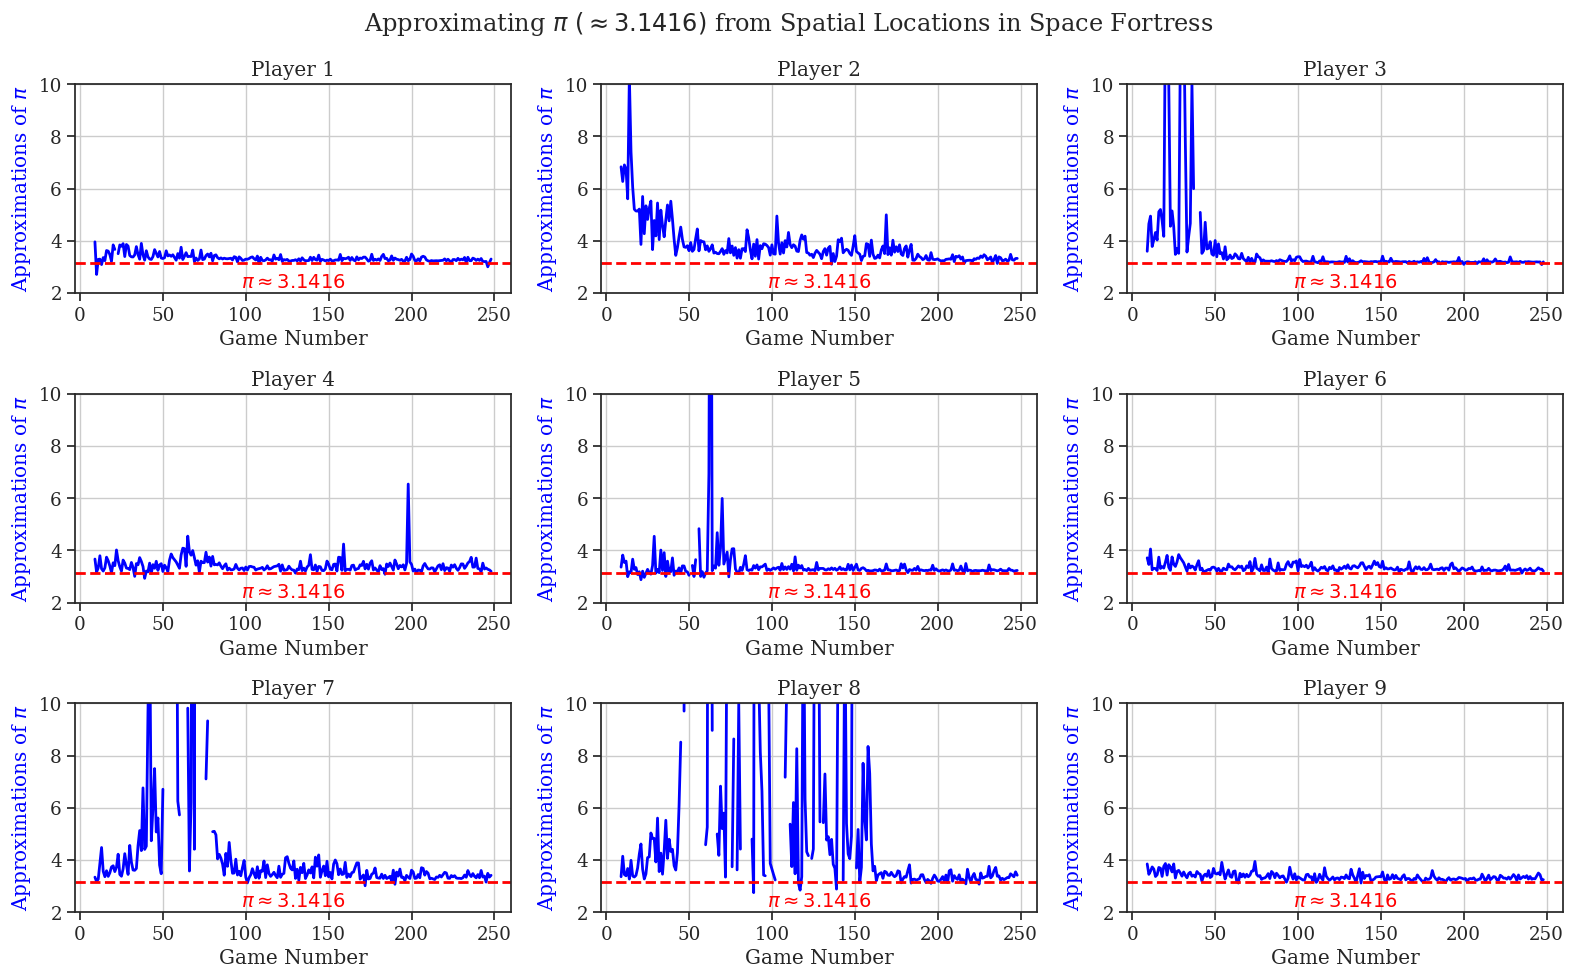

In [11]:
num_rows = 3
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize = (16, 10))

for player in range(1,10):
    fig_ix, fig_iy = int((player-1)/num_rows), (player-1)%num_cols
    ax = axs[fig_ix, fig_iy]
    to_plot = agg_df.loc[(agg_df.pid == player) & (agg_df.game >= 9)]
    # print(to_plot.game)

    ax.plot(to_plot.game, to_plot.pi_per_game, lw = 2, color = "blue")
    ax.axhline(y = 3.1416, color = 'red', ls = "--", lw = 2)
    ax.grid()
    ax.text(0.5, 0.05, r"$\pi \approx 3.1416$", color = 'red', 
         transform = ax.transAxes, fontsize=14, verticalalignment='center', horizontalalignment = 'center',bbox= None)
    ax.set_xlabel("Game Number")
    ax.set_ylabel(r"Approximations of $\pi$", color = "blue")
    ax.set_title("Player %i"%player)
    ax.set_ylim([2, 10])

plt.suptitle(r"Approximating $\pi\ (\approx 3.1416)$ from Spatial Locations in Space Fortress")
fig.tight_layout()
plt.show()
plt.close()

## Zooming in

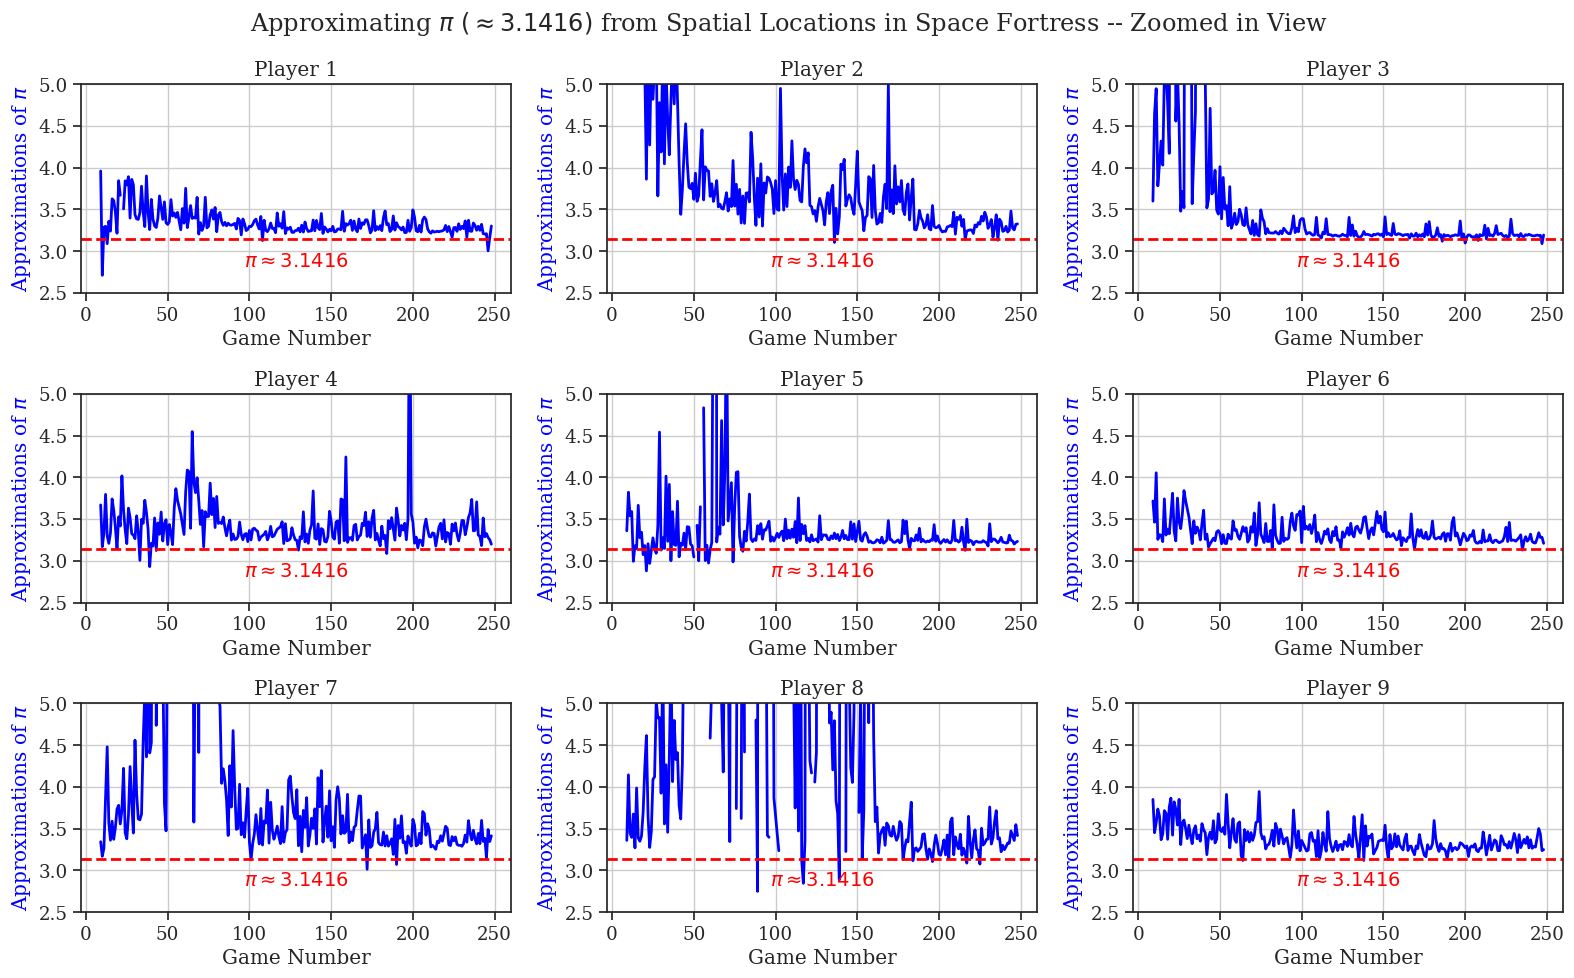

In [13]:
num_rows = 3
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize = (16, 10))
  

   
for player in range(1,10):
    fig_ix, fig_iy = int((player-1)/num_rows), (player-1)%num_cols
    ax = axs[fig_ix, fig_iy]
    to_plot = agg_df.loc[(agg_df.pid == player) & (agg_df.game >= 9)]
    # print(to_plot.game)

    ax.plot(to_plot.game, to_plot.pi_per_game, lw = 2, color = "blue")
    ax.axhline(y = 3.1416, color = 'red', ls = "--", lw = 2)
    ax.grid()
    ax.text(0.5, 0.15, r"$\pi \approx 3.1416$", color = 'red', 
         transform = ax.transAxes, fontsize=14, verticalalignment='center', horizontalalignment = 'center',bbox= None)
    ax.set_xlabel("Game Number")
    ax.set_ylabel(r"Approximations of $\pi$", color = "blue")
    ax.set_title("Player %i"%player)
    ax.set_ylim([2.5, 5])

plt.suptitle(r"Approximating $\pi\ (\approx 3.1416)$ from Spatial Locations in Space Fortress -- Zoomed in View")
fig.tight_layout()
plt.show()
plt.close()

In [19]:
index_in_agg_df = agg_df.loc[(agg_df["pid"] == 2) & (agg_df["game"] == 20)].index[0]
X = agg_df.at[index_in_agg_df, "X_arr"]
Y = agg_df.at[index_in_agg_df, "Y_arr"]


## Functions for Game-wise Animation

In [22]:
missed_data_list = []

player_list = range(1,10) # range(1,10)
sid_list = [1133, 1639, 1965, 2237, 3154, 3534, 4171, 5754, 6547]
day_list = range(1,32) # range(1,32)
game_list = range(1,9) # range(1,9)

t_old = time.time()

r = 200
x0 = (355-r); y0 = 315
x1 = (355-r/2); y1 = 315 - r*1.125
x2 = (355+r/2); y2 = 315 - r*1.125
x3 = (355+r); y3 = 315
x4 = (355+r/2); y4 = 315 + r*1.125
x5 = (355-r/2); y5 = 315 + r*1.125
points = [(x0, y0), (x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5)]


# Animates game_wise trajectories for a given player
def anim(player): 
	sid = sid_list[player-1]
	fig = plt.figure()

	# fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1]})

	fig, ax0 = plt.subplots(1,1)

	ax0.axis('equal')
	ax0.set_facecolor('black')
	ax0.plot(*zip(*(points+points[:1])), color = 'green', marker='o', lw = 4)
	ax0.plot(355,315,'r+', markersize = 10, label = 'Fortress', markeredgewidth = 2)
	ax0.set_xlim([0,710]); ax0.set_ylim([0,630])
	ax0.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False)
	ax0.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)

	next_zoid_text = ax0.text(1, 2, '',color='black', fontsize = 12)

	def animate_main(ov_game_number):
		day = np.ceil(ov_game_number/8.)
		game = ov_game_number - (day-1)*8
		index_in_agg_df = agg_df.loc[(agg_df["pid"] == player) & (agg_df["game"] == ov_game_number)].index[0]
		X = agg_df.at[index_in_agg_df, "X_arr"] + 355
		Y = agg_df.at[index_in_agg_df, "Y_arr"] + 315
		xx = ax0.plot(X, Y, 'b.')
		# next_zoid_text.set_text('Game number: %i' %ov_game_number)
		# print ov_game_number
		return xx

	# def animate_text(i):
	# 	ax1.set_xlim([0.,4.]); ax1.set_ylim([0.,3])
	# 	next_zoid_text.set_text('Game number: %i' %i)
	# 	return next_zoid_text,

	ani_main = animation.FuncAnimation(fig, animate_main, np.arange(1,248),
	                       interval = 50, blit = True, repeat = False)
	# ani_text = animation.FuncAnimation(fig, animate_text, np.arange(1,248),
 #                           interval = 50, blit = True, repeat = False)

	# plt.grid(True,color='white',ls='solid')


	# ---> To display the animation in a notebook, we need the following lines:
	# from IPython.display import HTML
	# HTML(ani.to_html5_video())

	# NOTE: Setting up FFMPEG
		# download the latest "release" version of ffmpeg from here: https://www.gyan.dev/ffmpeg/builds/
		# Extract the zip, and set the path to the executable below to match with the extracted folder.
	
	import matplotlib as mpl
	mpl.rcParams['animation.ffmpeg_path'] = r'C:\\ffmpeg\\bin\\ffmpeg.exe'

	# Save as gif
	# f = 'player_%i_trajectories_across_games.gif'%player
	# writergif = animation.PillowWriter(fps=3) 
	# ani_main.save(f, writer=writergif)

	# # Save animation on disk as mp4
	# # Way 1, worked after setting the path to the ffmpeg.exe
	f = 'player_%i_trajectories_across_games.mp4'%player
	FFwriter = animation.FFMpegWriter(fps=3, extra_args=['-r', '25'])
	ani_main.save('player_%i_trajectories_over_games.mp4'%player, writer=FFwriter)
	# Way 2, did not work :(
	# ani_main.save("Network_changes_with_Experience.mp4", writer = "ffmpeg")

	plt.show()
	plt.close()
# # --------------------------------------------Animation Function ends

<Figure size 640x480 with 0 Axes>

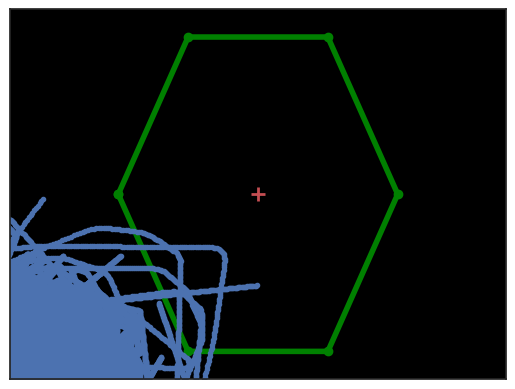

In [23]:
anim(7)

[[<AxesSubplot: > <AxesSubplot: >]
 [<AxesSubplot: > <AxesSubplot: >]]
[[<AxesSubplot: > <AxesSubplot: >]
 [<AxesSubplot: > <AxesSubplot: >]]


[1, 2, 3, 4, 5, 6, 7, 8, 9]

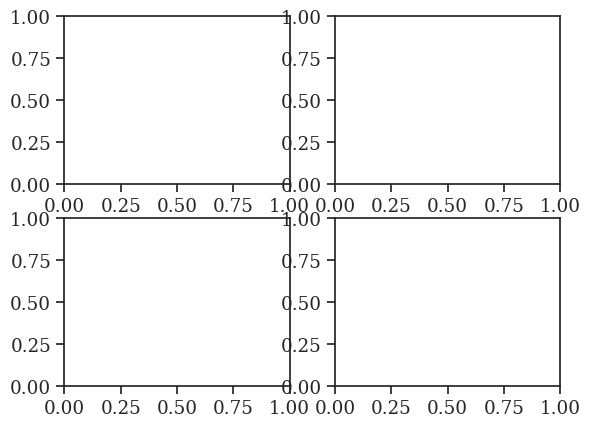

In [28]:
fig, axs = plt.subplots(2,2)

for ax in axs: print(axs)
list(range(1,10))

# References

Link to dataset available open-source: https://osf.io/v5mzx/

Destefano, M. (2010). The mechanics of multitasking: The choreography of perception, action, and cognition over 7.05 orders of magnitude. Rensselaer Polytechnic Institute.

Destefano, M., & Gray, W. D. (2016). Where Should Researchers Look for Strategy Discoveries during the Acquisition of Complex Task Performance? The Case of Space Fortress. In CogSci.

Gray, W. D., & Lindstedt, J. K. (2017). Plateaus, dips, and leaps: Where to look for inventions and discoveries during skilled performance. Cognitive science, 41(7), 1838-1870.

Rahman, R., & Gray, W. D. (2020). SpotLight on Dynamics of Individual Learning. Topics in Cognitive Science, 12(3), 975-991.